##### Initialization: definition of robots and coordinates

In [1]:
import numpy as np
from UAV import *
import random
import matplotlib.pyplot as plt   


n_robots = 5#int(input("number of robots: "))
n_components = 2
platoon = []


# initialization of n robots
for i in range(n_robots):
    if i==0:
        i_robot = Robot("op_" + str(i),0,0,0)
    else:
        i_robot = Robot("op_" + str(i),random.uniform(0, 10.0),random.uniform(0, 10.0),0)
    platoon.append(i_robot)

coordinates = [[],[],[]]

for rob in platoon:
    coordinates = np.append(coordinates,rob.get_coords(),axis=1)

#TRUE COORDINATES [REALITY: THEY ARE UNKNOWN]
S = coordinates[0:2,:]

print(S)

[[0.         1.93100999 5.18323072 7.75055881 3.55988551]
 [0.         2.25998608 1.76350182 8.59424874 9.92901738]]


##### Definition of the (squared) distance matrix

In [2]:
DM2 = d_matrix2(platoon) #squared distance matrix -> for formulas
print(DM2)

#double check the distances
print('\n',DM2 - DM_from_S(S))

[[  0.           8.83633668  29.97581938 133.9322733  111.25817097]
 [  8.83633668   0.          10.82343632  73.99003189  61.46727648]
 [ 29.97581938  10.82343632   0.          53.25027709  69.31089412]
 [133.9322733   73.99003189  53.25027709   0.          19.34335002]
 [111.25817097  61.46727648  69.31089412  19.34335002   0.        ]]

 [[ 0.00000000e+00 -1.77635684e-15 -3.55271368e-15  0.00000000e+00
   0.00000000e+00]
 [-1.77635684e-15  0.00000000e+00  1.77635684e-15 -1.42108547e-14
   0.00000000e+00]
 [-3.55271368e-15  1.77635684e-15  0.00000000e+00 -1.42108547e-14
  -1.42108547e-14]
 [ 0.00000000e+00 -1.42108547e-14 -7.10542736e-15  0.00000000e+00
   2.84217094e-14]
 [ 0.00000000e+00  0.00000000e+00 -1.42108547e-14  2.84217094e-14
   0.00000000e+00]]


##### S* estimation through EigenValue Decomposition

In [3]:
S_star = EVD(DM2,n_components)
print(S_star)

[[ 5.46586714  2.84374631  1.75791584 -5.68272248 -4.87815348]
 [ 1.67657189  0.17819854 -2.77485639 -1.414135    2.62985644]]


##### Removal of the ambiguity generated by distances in an Universal Euclidean transformation

In [4]:
#Translation removal
S_star = match_anchor(S,S_star,verbose=1)
print(S_star)

X displacement:  -5.465867135292811
Y displacement:  -1.6765718864425057
Displacement matrix:
 [[-5.46586714 -5.46586714 -5.46586714 -5.46586714 -5.46586714]
 [-1.67657189 -1.67657189 -1.67657189 -1.67657189 -1.67657189]]
[[  0.          -2.62212083  -3.7079513  -11.14858962 -10.34402062]
 [  0.          -1.49837335  -4.45142828  -3.09070688   0.95328455]]


The new coordinates may be affected by rotation and flip ambiguities. Thus we must solve the problem with further analysis

##### Identification of rotation ambiguity

DM' : a new acquisition for the distances

We now introduce a displacement for the anchor, in order to build a new (squared) distance matrix.

In reality what we do is applying a displacement to the anchor and we get a new distance matrix

In [5]:
deltaX1 = 0.3
deltaY1 = 0.1

DeltaS_prime = np.array([[0 for i in range(n_robots)] for j in range(2)],dtype=float)
DeltaS_prime[:,0] = [deltaX1,deltaY1]

S_prime = S + DeltaS_prime
print(S_prime)

DM_prime = DM_from_S(S_prime,verbose=1)

[[0.3        1.93100999 5.18323072 7.75055881 3.55988551]
 [0.1        2.25998608 1.76350182 8.59424874 9.92901738]]
DM' :
 [[  0.           7.32573347  26.61318058 127.66308827 107.23643619]
 [  7.32573347   0.          10.82343632  73.99003189  61.46727648]
 [ 26.61318058  10.82343632   0.          53.25027709  69.31089412]
 [127.66308827  73.99003189  53.25027709   0.          19.34335002]
 [107.23643619  61.46727648  69.31089412  19.34335002   0.        ]]


Estimation of the rotation angle $\theta_r$

In [6]:
theta_r   = estimate_theta(DM2,DM_prime,S_star,[deltaX1,deltaY1],verbose=1)

Coordinates to work with: 1-th and 2-th
After normalization: 
cos(theta):	-0.776649
sin(theta):	-0.629933

Actual theta:	 -2.4601255431960922
Approx theta:	Disabled


S** : estimated-rotated coordinates

In [7]:
S_star2 = rotateMatrix(theta_r)@S_star

##### Identification of flip ambiguity

We have to check if there is any flip ambiguity. To do so, we have to move the anchor one more time

In [8]:
deltaX2 = 0.7
deltaY2 = 0.4

DeltaS_prime2 = np.array([[0 for i in range(n_robots)] for j in range(2)],dtype=float)
DeltaS_prime2[:,0] = [deltaX2,deltaY2]

S_prime2 = S + DeltaS_prime2
print(S_prime)

DM_prime2 = DM_from_S(S_prime2,verbose=1)

[[0.3        1.93100999 5.18323072 7.75055881 3.55988551]
 [0.1        2.25998608 1.76350182 8.59424874 9.92901738]]
DM' :
 [[  0.           4.97493383  21.95849491 116.85609197  98.98111735]
 [  4.97493383   0.          10.82343632  73.99003189  61.46727648]
 [ 21.95849491  10.82343632   0.          53.25027709  69.31089412]
 [116.85609197  73.99003189  53.25027709   0.          19.34335002]
 [ 98.98111735  61.46727648  69.31089412  19.34335002   0.        ]]


Now we estimate a second rotation angle $\theta_{r2}$: if = 0, no flip ambiguity

theta_r2 :  -0.5
Wrong estimated angle: -2.4601255431960922
True  estimated angle: -1.3249682191869856


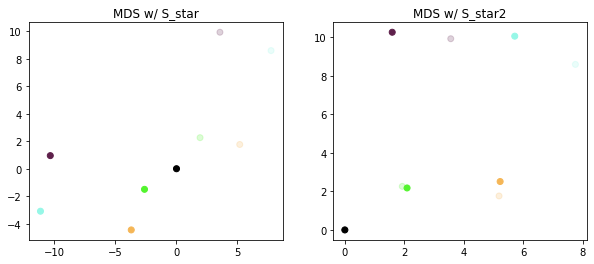

[[ 0.         -0.16043478 -0.03673601  2.03965401  1.96719371]
 [ 0.          0.08133992 -0.74967622 -1.46701787 -0.33601291]]


In [9]:
theta_r2 = estimate_theta(DM2,DM_prime2,S_star2,[deltaX2,deltaY2],approx=2,verbose=0)
print("theta_r2 : ", theta_r2)


if (theta_r2 != 0):
  F = np.array([[-1,0],[0,1]])
    
  theta_r3 = estimate_theta(DM2,DM_prime,F@S_star,[deltaX1,deltaY1],verbose=0)

  print("Wrong estimated angle:",theta_r)
  print("True  estimated angle:", theta_r3)

  S_star2 = rotateMatrix(theta_r3)@F@S_star


plot_points(S,S_star  = S_star,
              S_star2 = S_star2
            )
print(S-S_star2)

3.6168631362038313
-2.4601255431960922


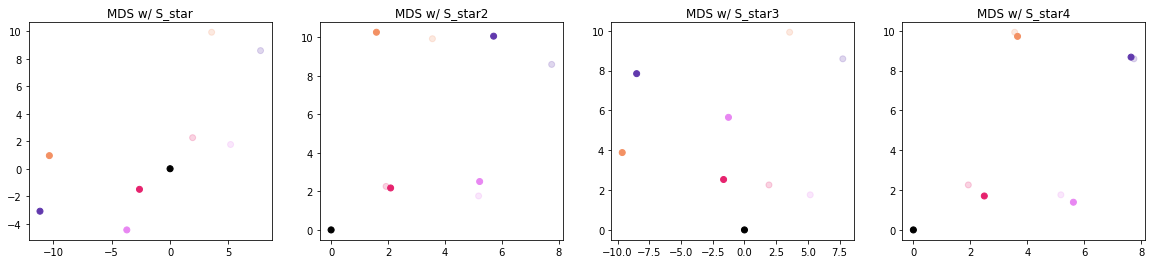

In [10]:
theta = LSE(DM2,DM_prime,S_star,[deltaX1,deltaY1])
print(theta.x)
print(theta_r)

theta_f = LSE(DM2,DM_prime,F@S_star,[deltaX1,deltaY1])

plot_points(S,S_star  = S_star,
              S_star2 = S_star2,
              S_star3 = rotateMatrix(theta.x)@F@S_star,
              S_star4 = rotateMatrix(theta_f.x)@F@S_star
            )